In [147]:
import numpy as np 
import matplotlib.pyplot as plt 

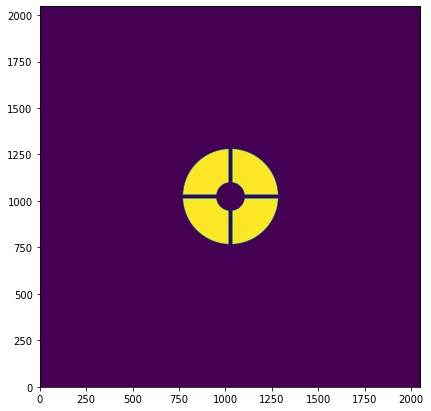

In [148]:
#Telescope, with some obstructions in the place:
R = 0.25 # radius of the aperture, say a telescope
N = 2048
x = np.linspace(-4*R,4*R,N)
y = np.linspace(-4*R,4*R,N)
A = np.zeros([N,N])
A[:,:] = 1.0

out = np.where(x[:,None]**2.0 + y[None,:]**2.0 > R**2.0) 

A[out] = 0.0
A[:,np.where(np.abs(y)<0.01)] = 0.0
A[np.where(np.abs(x)<0.01),:] = 0.0


inside = np.where(x[:,None]**2.0 + y[None,:]**2.0 < (0.3*R)**2.0)
A[inside] = 0.0

plt.figure(figsize=[10,7])
plt.imshow(A.T,origin='lower')


In [149]:
llambda = 630E-9
k = 2.0 * np.pi /llambda

E_p = np.fft.fft2(A)
inv_x = np.fft.fftfreq(x.shape[-1])
inv_x /= (x[1]-x[0])/2/np.pi
inv_y = np.fft.fftfreq(x.shape[-1])
inv_y /= (x[1]-x[0])/2/np.pi


inv_x = np.fft.fftshift(inv_x)
inv_y = np.fft.fftshift(inv_y)
E_p = np.fft.fftshift(E_p)
I_p = np.abs(E_p)**2.0
phi_fft = inv_x / k
theta_fft = inv_y/k

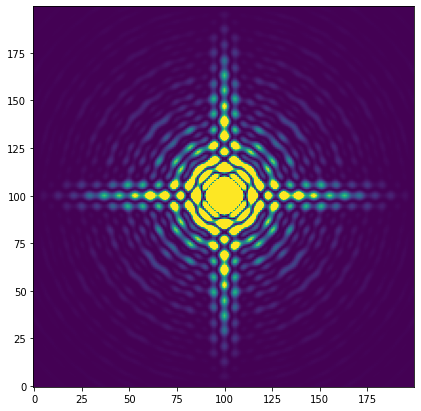

In [150]:
center = N//2
span = 100
plt.figure(figsize=[10,7])
plt.imshow((I_p[center-span:center+span,center-span:center+span]/np.max(I_p)),origin='lower',vmax=0.001)


     

In [151]:
print(phi_fft * 206265)

[-66.50035166 -66.43540991 -66.37046816 ...  66.30552641  66.37046816
  66.43540991]


In [152]:
# Here we want to add a little defocus:
#
defocus = 1.5E-3

# One arcsec has a size 

f = 9.1*0.5
D = 0.5

r_blur = D/f*defocus * 0.5
print (r_blur)

8.241758241758242e-05


In [153]:
pixel_size = 12.3E-3 / 1024

blur_in_pixels = r_blur / pixel_size 

print (blur_in_pixels)

6.861431251675154


In [154]:
N_psf = len(phi_fft)
print (N_psf)

2048


In [155]:
blur_in_angles = r_blur / f
print (blur_in_angles*206265)

blur_in_angles = 0.2 / 206265.0

3.736233546673107


In [156]:
print (blur_in_angles)
print (phi_fft[1000:1048])

9.696264514095946e-07
[-7.55630859e-06 -7.24146240e-06 -6.92661621e-06 -6.61177002e-06
 -6.29692383e-06 -5.98207764e-06 -5.66723145e-06 -5.35238525e-06
 -5.03753906e-06 -4.72269287e-06 -4.40784668e-06 -4.09300049e-06
 -3.77815430e-06 -3.46330811e-06 -3.14846191e-06 -2.83361572e-06
 -2.51876953e-06 -2.20392334e-06 -1.88907715e-06 -1.57423096e-06
 -1.25938477e-06 -9.44538574e-07 -6.29692383e-07 -3.14846191e-07
  0.00000000e+00  3.14846191e-07  6.29692383e-07  9.44538574e-07
  1.25938477e-06  1.57423096e-06  1.88907715e-06  2.20392334e-06
  2.51876953e-06  2.83361572e-06  3.14846191e-06  3.46330811e-06
  3.77815430e-06  4.09300049e-06  4.40784668e-06  4.72269287e-06
  5.03753906e-06  5.35238525e-06  5.66723145e-06  5.98207764e-06
  6.29692383e-06  6.61177002e-06  6.92661621e-06  7.24146240e-06]


In [157]:
inside = np.where((phi_fft[:,None]**2.0 + theta_fft[None,:]**2.0) < blur_in_angles **2.0)

In [158]:
blur_kernel = np.zeros([N_psf,N_psf])

In [159]:
blur_kernel[inside] = 1.0

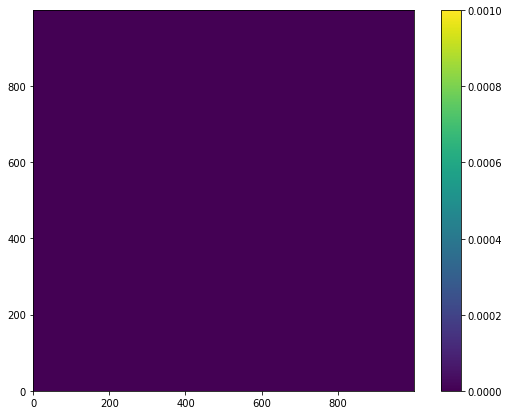

In [160]:
center = N//2
span = 500
plt.figure(figsize=[10,7])
plt.imshow((blur_kernel[center-span:center+span,center-span:center+span]/np.max(I_p)),origin='lower',vmax=0.001)
plt.colorbar()

     

In [161]:
print (np.sum(blur_kernel))

29.0


In [162]:
print (blur_kernel[1021:1028,1021:1028])

[[0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


In [116]:
from scipy.signal import convolve2d

In [168]:
PSF_final = convolve2d(I_p, blur_kernel[1021:1028,1021:1028],mode='same')

In [169]:
print (PSF_final.shape)


(2048, 2048)


In [170]:
# Reinterpolate PSF

N_small = 127
PSF_small = np.zeros([N_small,N_small])
pixel_size = 16.0 # in km
pixel_size_arcsec = pixel_size / 725.0 # in arcsec
theta_small = np.linspace(-(N_small-1.0)*0.5*pixel_size_arcsec,\
                          (N_small-1.0)*0.5*pixel_size_arcsec, N_small)
phi_small = np.linspace(-(N_small-1.0)*0.5*pixel_size_arcsec,\
                          (N_small-1.0)*0.5*pixel_size_arcsec, N_small)





In [171]:
from scipy.interpolate import interp2d

f = interp2d(phi_fft*206265., phi_fft*206265., PSF_final, kind='linear')

PSF_small = f(theta_small, phi_small)

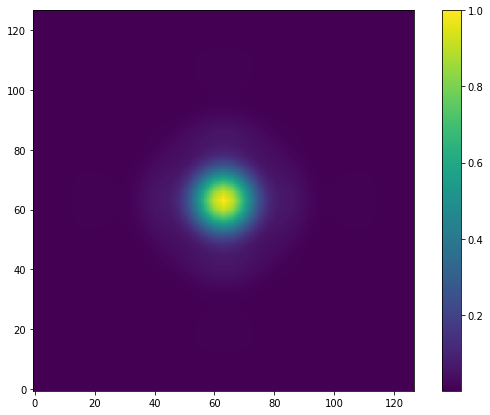

In [172]:
plt.figure(figsize=[10,7])
plt.imshow(PSF_small / np.amax(PSF_small),origin='lower',vmax=1.0)
plt.colorbar()

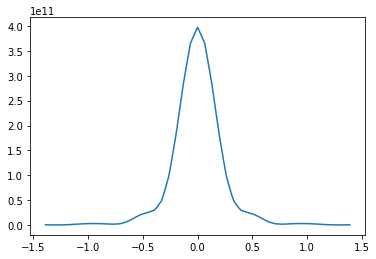

In [173]:
plt.plot(phi_small,PSF_small[64,:])

In [174]:
PSF_small = PSF_small / np.sum(PSF_small)

In [175]:
from astropy.io import fits

In [176]:
kekbur = fits.PrimaryHDU(PSF_small)
kekbur.writeto("hinodepsf.fits",overwrite=True)